## EDA

### Подключение библиотек и загрузка данных

In [82]:
# Стандартная библиотека
import sys
sys.path.insert(0, '/home/alorozhkov/jup/ml_projects/Marketing_Response/utils/')
sys.path.insert(0, '/home/alorozhkov/jup/ml_projects/Marketing_Response/src/')


import os
from getpass import getpass


import time
from tqdm import tqdm


import warnings
warnings.filterwarnings("ignore", module="matplotlib.font_manager")


import numpy as np
np.random.seed(42)


import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = lambda x: ('%.12f' % x).rstrip('0').rstrip('.')

#Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager
font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
plt.rcParams['font.family'] = 'DejaVu Sans'


#MLFlow
import mlflow
mlflow.set_tracking_uri(f'http://127.0.0.1:5000/')
mlflow.set_experiment("Marketing_Response")

#AutoML
from pycaret.classification import *


#Стат тесты
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from scipy.stats import norm
from scipy.stats import probplot
from scipy.stats import shapiro
from scipy.stats import stats
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Нормализация и балансировка данных
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

#Подбор гиперпарамметров
from sklearn.model_selection import (
    GridSearchCV, StratifiedKFold, train_test_split
)


#Обучение модели
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

#Метрики
from sklearn.metrics import (
    average_precision_score, confusion_matrix, ConfusionMatrixDisplay,
    f1_score, precision_score, recall_score, roc_auc_score,
    PrecisionRecallDisplay, RocCurveDisplay
)

# Отбор признаков
from sklearn.feature_selection import SelectKBest, f_classif
import shap

# Импорт вспомогательных функций
from data_preprocessing import remove_outliers_iqr
from features import *

In [5]:
#Пути к данным
processed_data = '/home/alorozhkov/jup/ml_projects/Marketing_Response/data/processed/MK_PROCESSED_DATA.csv'
processed_eda_data = '/home/alorozhkov/jup/ml_projects/Marketing_Response/data/processed/MK_PROCESSED_EDA_DATA.csv'

In [6]:
#Загрузка данных
data = pd.read_csv('/home/alorozhkov/jup/ml_projects/Marketing_Response/data/processed/MK_PROCESSED_DATA.csv')
data.head(2)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0


### Создание новых признаков, первичный EDA

In [7]:
#Вывожу стат информацию по всем признакам
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,2216,5588.35333935018,3249.376274813471,0,2814.75,5458.5,8421.75,11191
Year_Birth,2216,1968.820397111913,11.985554097352,1893,1959,1970,1977,1996
Income,2216,52247.251353790612,25173.076660901403,1730,35303,51381.5,68522,666666
Kidhome,2216,0.44178700361,0.536896240135,0,0,0,1,2
Teenhome,2216,0.505415162455,0.54418121154,0,0,0,1,2
Recency,2216,49.012635379061,28.948351658625,0,24,49,74,99
MntWines,2216,305.091606498195,337.327920116672,0,24,174.5,505,1493
MntFruits,2216,26.356046931408,39.793916518239,0,2,8,33,199
MntMeatProducts,2216,166.995938628159,224.283272758982,0,16,68,232.25,1725
MntFishProducts,2216,37.637635379061,54.752082414852,0,3,12,50,259


Вывод:
- Income, Year_Birth имеют выбросы(возраст=1893 и 1899, доход 666 666 со средним = 52 247 - выброс)
- Z_CostContact, Z_Revenue	 - столбцы не несущие никакой информации --> нужно удалить
- Complain - всего 0.09 жалоб --> слишком мало для дальнейшего анализа --> нужно удалить

In [8]:
#Преобразую дату рождения в возраст для более удобного анализа
data['Age'] = 2025 - data['Year_Birth']

Нам не важен возраст ребенка в семье, а только есть дети в семье или нет. 
Поэтому, целесообразней создать новый признак по наличию детей не зависимо от их возраста
Ниже создаю новый признак HasChildren

In [9]:
# Создание признака HasChildren
data['HasChildren'] = (data[['Kidhome', 'Teenhome']].sum(axis=1) > 0).astype(int)

In [10]:
# Вывожу уникальные значения по полю Marital_Status
data['Marital_Status'].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

Создаю новый признак MaritalFlag- если в отношения=1 иначе 0

In [11]:
# Добавление фичи MaritalFlag 
data['MaritalFlag'] = data['Marital_Status'].isin(['Married', 'Together']).astype(int)

Нас не интересует какие покупки, а именно что покупают клиенты. Поэтому создаю новый признак TotalSpent который показывает сумму трат покупателя.

In [12]:
# Создаю TotalSpent признак по сумме трат покупателей 
mnt_cols = [
    'MntWines',          # траты на вино
    'MntFruits',         # траты на фрукты
    'MntMeatProducts',   # траты на мясо
    'MntFishProducts',   # траты на рыбу
    'MntSweetProducts',  # траты на сладости
    'MntGoldProds'       # траты на премиум товары
]
data['TotalSpent'] = data[mnt_cols].sum(axis=1)

Преобразую временные признаки для дальнейшего анализа

In [13]:
# Создаю новые столбцы по Dt_Customer 
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'], dayfirst=True)
data['Customer_Since_Days'] = (pd.Timestamp.today() - data['Dt_Customer']).dt.days
data['Customer_Since_Years'] = (data['Customer_Since_Days'] / 365.25).astype(int)

Для уменьшения кол-ва признаков и облегчения анализа данных, создаю признак вовлеченности покупателя TotalPurchaseActivity, которая отображает сумму всех покупок человека.

In [14]:
# Создаю Фичу вовлеченности покупателя
data['TotalPurchaseActivity'] = data[['NumCatalogPurchases', 'NumWebPurchases', 'NumStorePurchases', 'NumDealsPurchases']].sum(axis=1)

Участие в предыдущих кампаниях также преобразую к одному столбцу - TotalAcceptedCmp, который представляет из себя сумму по всем предыдущим кампаниям.

In [15]:
# Создаю фичу по кол-ву кампаний в которых ранее участвовал 
data['TotalAcceptedCmp'] = data[['AcceptedCmp1', 'AcceptedCmp3', 'AcceptedCmp5', 'AcceptedCmp2', 'AcceptedCmp4']].sum(axis=1)

In [16]:
# Создаю фичу по наличию высшего образования HigherEducation
higher_edu = ['Graduation', 'Master', 'PhD']
data['HigherEducation'] = data['Education'].isin(higher_edu).astype(int)

In [17]:
#Удаляю излишние столбцы из данных
cols = [
    'ID', 'Year_Birth', 'Education', 'Marital_Status', 'Kidhome', 'Teenhome', 
    'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 
    'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
    'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
    'Z_CostContact', 'Z_Revenue', 'Dt_Customer', 'Customer_Since_Days', 'Customer_Since_Years', 'Complain'
]
data.drop(cols, axis=1, inplace=True) 

Удаляю дубликаты:

In [18]:
#Вывожу дубликаты
duplicates = (data[data.duplicated(keep='first')]).sum()
print(duplicates)

Income                  9402629
Recency                    9314
NumWebVisitsMonth           980
Response                     23
Age                       10330
HasChildren                 124
MaritalFlag                 128
TotalSpent               109907
TotalPurchaseActivity      2726
TotalAcceptedCmp             50
HigherEducation             165
dtype: float64


In [19]:
#Удаляю дубликаты
data = data.drop_duplicates(keep='first')

### Анализ числовых признаков

In [20]:
data.head(2)

,Income,Recency,NumWebVisitsMonth,Response,Age,HasChildren,MaritalFlag,TotalSpent,TotalPurchaseActivity,TotalAcceptedCmp,HigherEducation
0,58138,58,7,1,68,0,0,1617,25,0,1
1,46344,38,5,0,71,1,0,27,6,0,1


Описательная статистика по данным указала на наличие выбросов по некоторым столбцам.

Для обработки выбросов буду использовать метож межквартильного размаха (IQR)

Данный метод надежен для обнаружения и удаления выбросов т.к.:

- Он вычисляет разницу между 25-м процентилем (Q1) и 75-м процентилем (Q3).
- Выбросами определяются значения, попадающие ниже диапазона Q1 - 1,5 * IQR или выше диапазона Q3 + 1,5 * IQR.
- Данный метод помогает уменьшить влияние экстремальных значений, делая модель более стабильной.
Так как возможные выбросы были обнаружены в различных числовых признаках, пишу функцию для удобства

In [21]:
columns_to_clean = ['Age', 'TotalSpent', 'Income']

# Удаление выбросов для каждого признака из columns_to_clean
for col in columns_to_clean:
    original_shape = data.shape[0]  # Изначальный размер данных до удаления
    data = remove_outliers_iqr(data, col)  # Применяю функцию выше для удаления
    new_shape = data.shape[0]  # Данные после удаления
    print(f"Удалено {original_shape - new_shape} выбросов с '{col}' столбца.")

print(f"\nРазмер датасета без выбросов: {data.shape}")

Удалено 3 выбросов с 'Age' столбца.
Удалено 3 выбросов с 'TotalSpent' столбца.
Удалено 8 выбросов с 'Income' столбца.

Размер датасета без выбросов: (2017, 11)


После удаления выбросов, проверяю каждый признак визуально + смотрю распределение данных по признакам

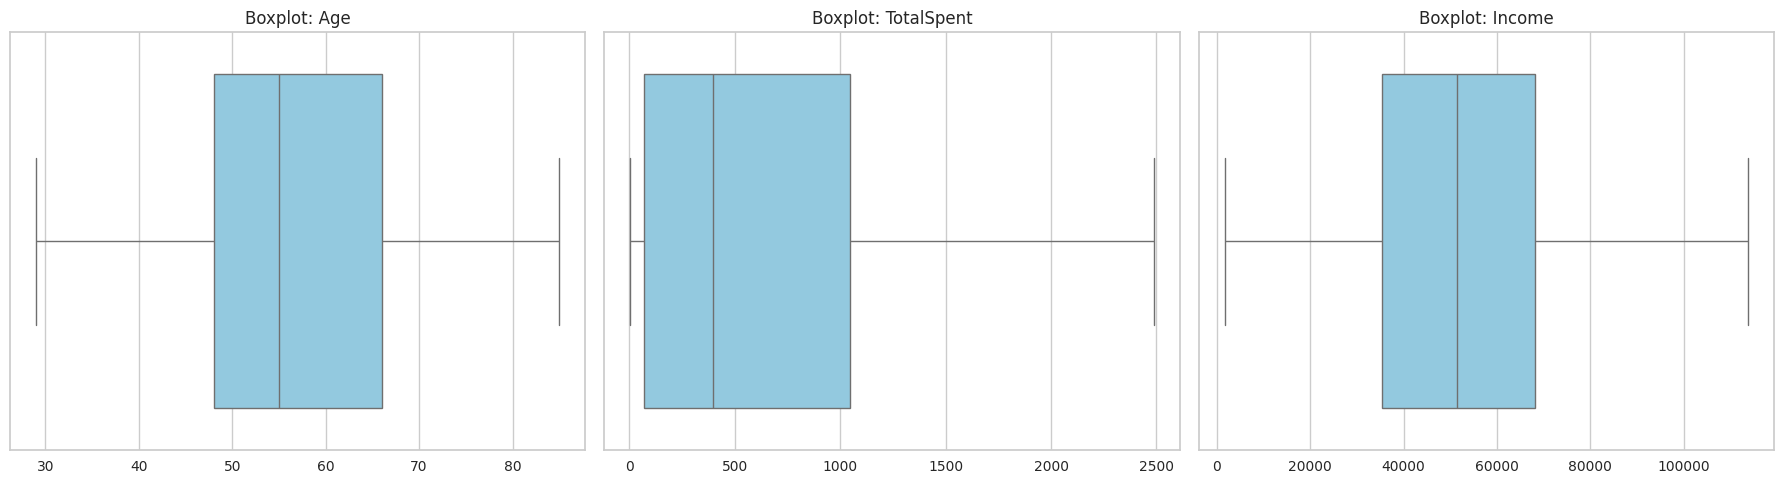

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 строка, 3 столбца

for i, feature in enumerate(columns_to_clean):
    sns.boxplot(data=data, x=feature, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Boxplot: {feature}')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

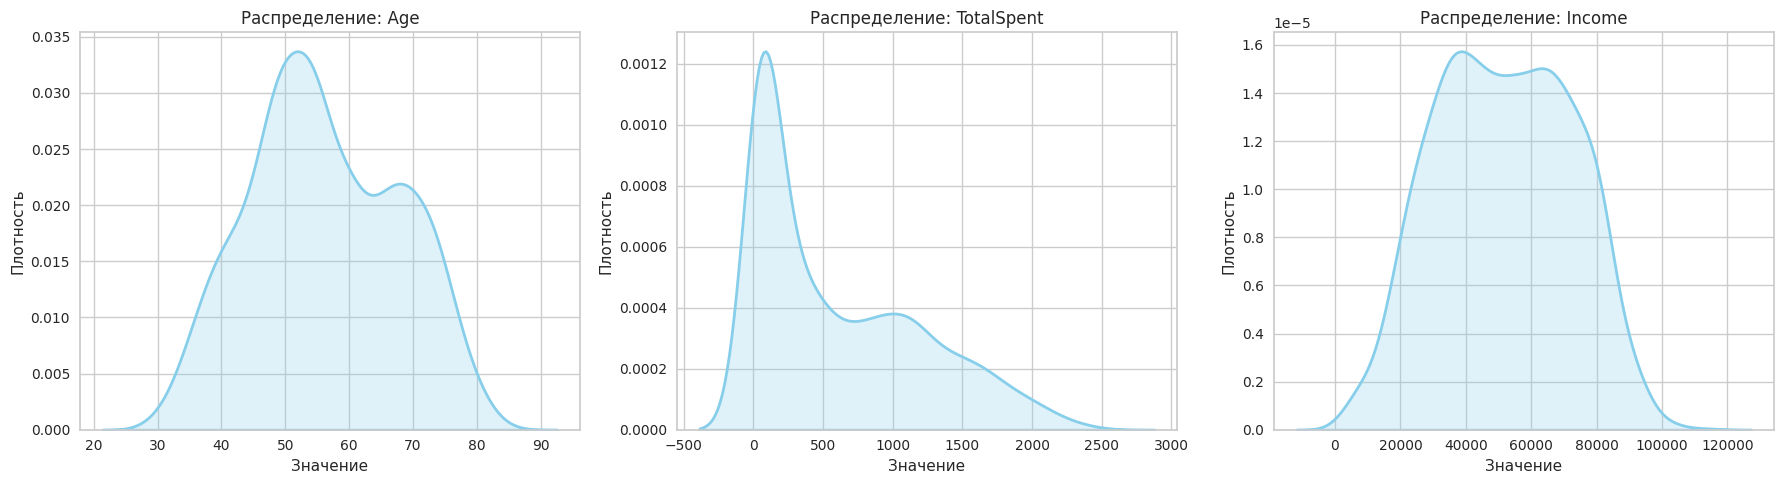

In [23]:
columns_to_clean = ['Age', 'TotalSpent', 'Income']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 строка, 3 графика

for i, feature in enumerate(columns_to_clean):
    sns.kdeplot(data[feature], fill=True, ax=axes[i], color='skyblue', linewidth=2)
    axes[i].set_title(f'Распределение: {feature}')
    axes[i].set_xlabel('Значение')
    axes[i].set_ylabel('Плотность')

plt.tight_layout()
plt.show()

Видим по графику boxplot что выбросы в переменных Age, Income, TotalSpent удалены.

По распределниям признаков видим что TotalSpent лучше логарифмировать, Income распределение блтзко к нормальному, а Age скошено вправо.

Перехожу к дальнейшему анализу этих признаков

In [24]:
#Сводная информация по Income
print(data['Income'].describe())

count                 2017
mean    51638.639067922661
std     20678.666258268542
min                   1730
25%                  35388
50%                  51411
75%                  68142
max                 113734
Name: Income, dtype: float64


Из сводной статистики видим, что распределение довольно симметричное, однако разброс дохода достаточно большой std = 20 000

Также видно, что диапазон значений достаточно большой min=1 730, а max = 11 3734

Лучше всего логарифмировать если всетаки буду использовать данный столбец в обучении модели 

Для более детального и упрощенного  анализа признака группирую Income по квантилям, где:

- Q1: 0–25% (низкий доход)
- Q2: 25–50%
- Q3: 50–75%
- Q4: 75–100% (высокий доход)

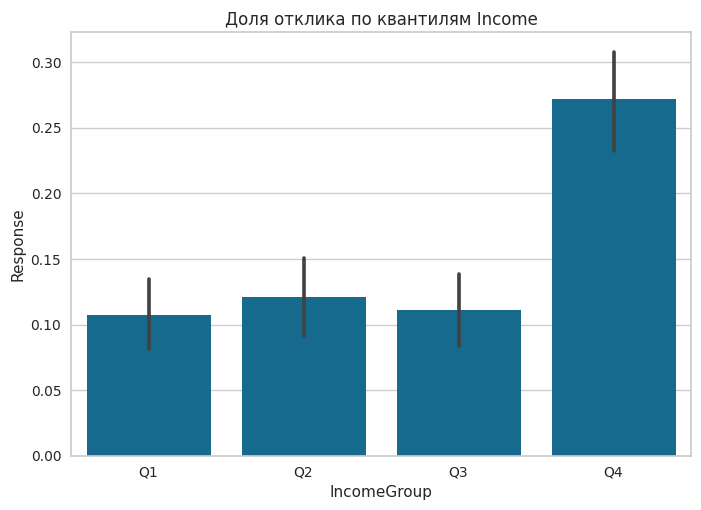

In [25]:
# Группировка по квантилям Income
data['IncomeGroup'] = pd.qcut(data['Income'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
sns.barplot(x='IncomeGroup', y='Response', data=data, estimator=np.mean)
plt.title('Доля отклика по квантилям Income')
plt.show()

На данном графике доля отклика (Response) по квантилям дохода (IncomeGroup).

Выводы по графику:

- У людей с высоким доходом(Q4) отклик существенно выше чем у всех остальных групп
- Первые три группы(Q1, Q2, Q3) примерно равны по уровню отклика

Т.е. уровень дохода существенно влияет на долю отклика

Что убедится еще раз в достоверности данной информации, проверяю статистическую значимость различий между Q4 и остальными квантилями, где:

- H0: Q4 и остальные квантили статистически не отдичаются
- H1: Q4 значительно отличается от остальных квантилей

In [26]:
group_q4 = data[data['IncomeGroup'] == 'Q4']['Response']
group_rest = data[data['IncomeGroup'].isin(['Q1', 'Q2', 'Q3'])]['Response']

t_stat, p_value = ttest_ind(group_q4, group_rest)
print(f'p-value: {p_value:.4f}')

p-value: 0.0000


Значение p-value< 0.05 говорит о том, что люди с самым высоким доходом (Q4) действительно чаще откликаются, и это не случайность, а устойчивая закономерность.
Поэтому мы отвергаем нулевую гипотезу!

Вывожу информацию по диапазонам дохода по ккаждому квантилю для дальнейшего анализа и преобразований.

In [27]:
# Группировка данных и расчёт метрик по интервалам
data['IncomeInterval'] = pd.qcut(data['Income'], q=4)  # создаём сами интервалы

response_by_income = data.groupby('IncomeInterval').agg(
    Средний_Response=('Response', 'mean'),
    Количество_клиентов=('Response', 'count')
).reset_index()

In [28]:
# Преобразую интервалы в строки для читаемости
response_by_income['Диапазон_дохода'] = response_by_income['IncomeInterval'].astype(str)
print(response_by_income[['Диапазон_дохода', 'Средний_Response', 'Количество_клиентов']])

       Диапазон_дохода  Средний_Response  Количество_клиентов
0  (1729.999, 35388.0]    0.106930693069                  505
1   (35388.0, 51411.0]    0.121031746032                  504
2   (51411.0, 68142.0]    0.111111111111                  504
3  (68142.0, 113734.0]    0.271825396825                  504


По числовому признаку Income можно сделать следующие выводы:
- Income(доход) - достаточно сильный предиктор отклика
- Люди с диапазоном дохода от 68 000 до 113 740 - это наша целевая аудитория(Q4)

Учитывая все эти факты, создаю новый бинарный признак IsHighIncome который указывает на уровень дохода человека, а именно:
- IsHighIncome=1 -высокий доход
- IsHighIncome=0 - не высокий доход

In [29]:
# Cоздаю бинарный признак богатых покупателей IsHighIncome
data['IsHighIncome'] = (data['IncomeGroup'] == 'Q4').astype(int)

Визуализирую, как отличается средний уровень отклика  между покупателями с высоким и более низким доходом. 

Данный график  поможет оценить значимость признака IsHighIncome.

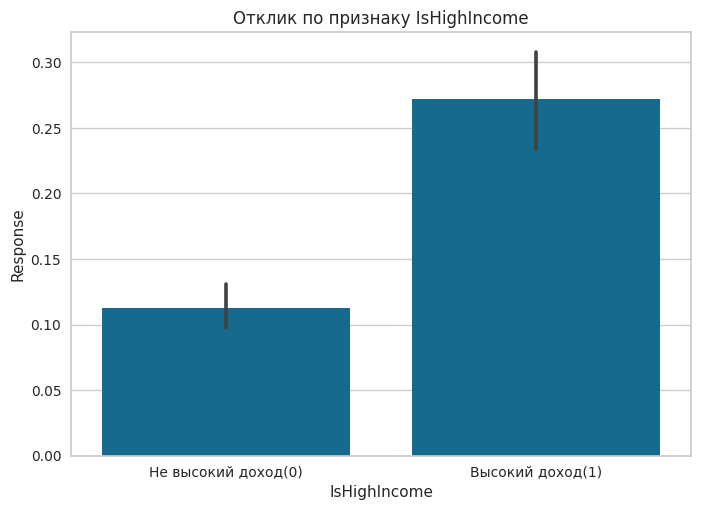

In [30]:
# Вывожу диаграмму, отражающую долю откликнувшихся в зависимости от принадлежности к группе
sns.barplot(x='IsHighIncome', y='Response', data=data, estimator=np.mean)
plt.title('Отклик по признаку IsHighIncome')
plt.xticks([0, 1], ['Не высокий доход(0)', 'Высокий доход(1)'])
plt.show()

По графику видно, что доля откликнувшися намного больше среди покупателей с высоким доходом.

Чтобы удостовериться в увиденном на графике, проведу t-test

Проверяю, влияет ли принадлежность к группе IsHightIncome на вероятность отклика.

H0: Средний отклик одинаков для богатых и небогатых клиентов.

H1: Средний отклик различается.

In [31]:
# Разделяю на две группы
high_income = data[data['IsHighIncome'] == 1]['Response']
low_income = data[data['IsHighIncome'] == 0]['Response']

# Провожу t-тест
t_stat, p_value = ttest_ind(high_income, low_income, equal_var=False)  # Welch’s t-test

print(f't-статистика: {t_stat:.4f}')
print(f'p-value: {p_value:.6f}')

t-статистика: 7.4058
p-value: 0.000000


По результатам теста получаем p-value < 0.05, а это значит , что признак IsHighIncome оказывает статистически значимое влияние на отклик.

Также видим достаточно высокое значение t-test означающее, что группа IsHighIncome=1 сильно отличается по отклику от остальных.

---> Отклоняем нулевую гипотезу и оставляем признак IsHighIncome для модели

In [32]:
#Логарифмирую Income для модели:
data['IncomeLog'] = np.log1p(data['Income']) 

Далеее анализирую числовой признак TotalSpent.

Для начала вывожу сводную статистику по этому признаку:

In [33]:
#Сводная информация по TotalSpent
print(data['TotalSpent'].describe())

count               2017
mean    605.136836886465
std     598.307063619919
min                    5
25%                   69
50%                  397
75%                 1045
max                 2486
Name: TotalSpent, dtype: float64


Из сводной статистики видим, что распределение асимметрично, — медиана(50%) =397 сильно меньше среднего(mean) = 605, значит есть богатые клиенты с очень большими тратами, которые "тянут" среднее вверх.

Данный признак сильно варьируется т.к. min = 5 а max = 2 486

Большинство покупателей (75%) тратят менее 1 045, следовательно покупатели с большими суммами - это меньшенство.

Лучше всего логарифмировать если всетаки буду использовать данный признак в обучении модели

Строю гистограмму распределения TotalSpent для понимания сколько покупателей попадает в определенный диапазон трат:

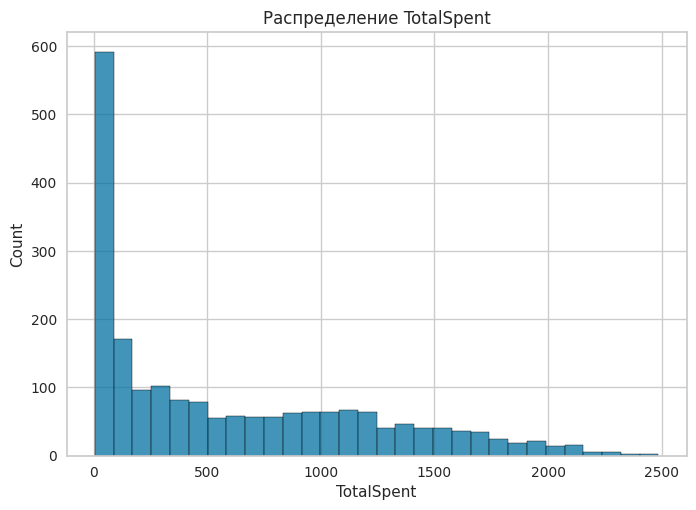

In [34]:
# Вывожу гистограмму распределения TotalSpent
sns.histplot(data['TotalSpent'], bins=30)
plt.title('Распределение TotalSpent')
plt.show()

По графику видим, что распределение скошено вправо, что говорит нам о незначительном кол-ве покупателей которые тратят > 1000

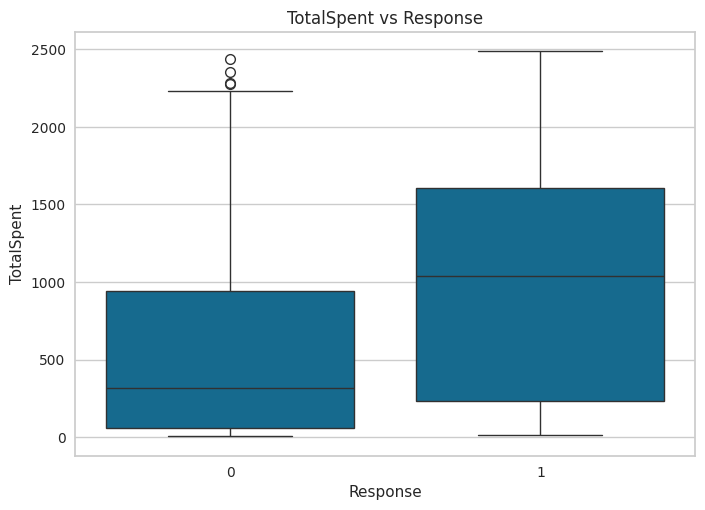

In [35]:
sns.boxplot(x='Response', y='TotalSpent', data=data)
plt.title('TotalSpent vs Response')
plt.show()

На графике видим сильные визуальные признаки того, что TotalSpent положительно влияет на вероятность отклика, а именно:
    
- Пользователи, откликнувшиеся на предложение, в среднем тратят гораздо больше (медиана намного выше)

- Верхние значения также значительно выше.

Используем стат тест для проверки важности данного признака. 
Для теста использую непараметрический тест — тест Манна–Уитни (Mann–Whitney U test), так как распределение скошено вправо и t-test в данном случае не подходит(нужно нормальное распределение).

H0: распределения TotalSpent одинаковы для групп Response = 0 и Response = 1

H1: распределения различаются

In [36]:
# Разделяю данные
spent_0 = data[data['Response'] == 0]['TotalSpent']
spent_1 = data[data['Response'] == 1]['TotalSpent']

In [37]:
# Применяю тест Манна–Уитни
stat, p = mannwhitneyu(spent_0, spent_1, alternative='two-sided')

print(f"U-статистика: {stat}")
print(f"p-value: {p}")

U-статистика: 163195.0
p-value: 2.2123466072814277e-26


Так как p-value < 0.05 мы уверенно отвергаем H0!

Признак TotalSpent очень важен для модели.

Однако, так как у нас скошенное распределение вправо, лучше применить логарифмирование над этим признаком.

In [38]:
# Логарифмирую TotalSpent признак
data['TotalSpentLog'] = np.log1p(data['TotalSpent']) 

Перехожу к анализу следующего числового признак - Age.

Для начала вывожу сводную статистику по этому признаку:

In [39]:
print(data['Age'].describe())

count              2017
mean     56.15071888944
std     11.650204828604
min                  29
25%                  48
50%                  55
75%                  66
max                  85
Name: Age, dtype: float64


По сводной статистике видим, что:
- Основное распределение сосредоточено в возрастной группе 48–66 лет.

Есть ли разница в возрасте между откликнувшимися или нет?

<Axes: xlabel='Response', ylabel='Age'>

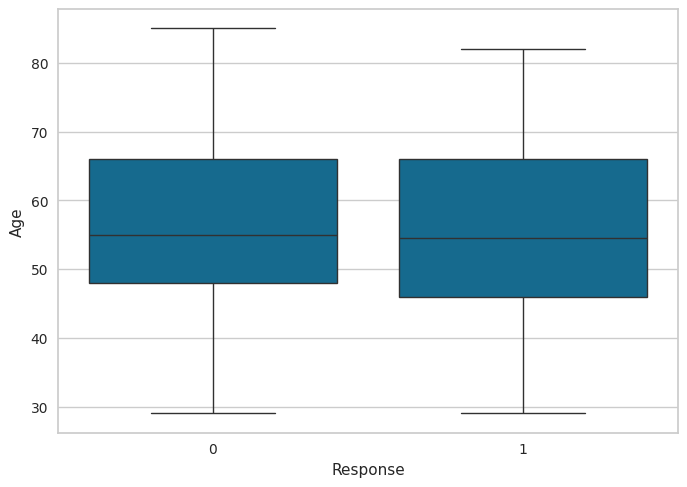

In [40]:
sns.boxplot(x='Response', y='Age', data=data)

Медианы и квантили значительно не различаются --> признак не информативен для разделения классов.

Чтобы убедится в этом, сравню распределение признака Age в разных классах Response:

In [41]:
# Группировка по Response и вывод статистик для Age
stats = data.groupby('Response')['Age'].describe()
display(stats)

,count,mean,std,min,25%,50%,75%,max
Response,,,,,,,,
0,1709,56.260386190755,11.532591231224,29,48,55,66,85
1,308,55.542207792208,12.284156170842,29,46,54.5,66,82


Видим, что признак Age  не демонстрирует заметного разделения между классами.

Проведу стат тест для очередной проверки информативностьи Age.

Прежде чем использовать стат тест, смотрю на распределение признака:

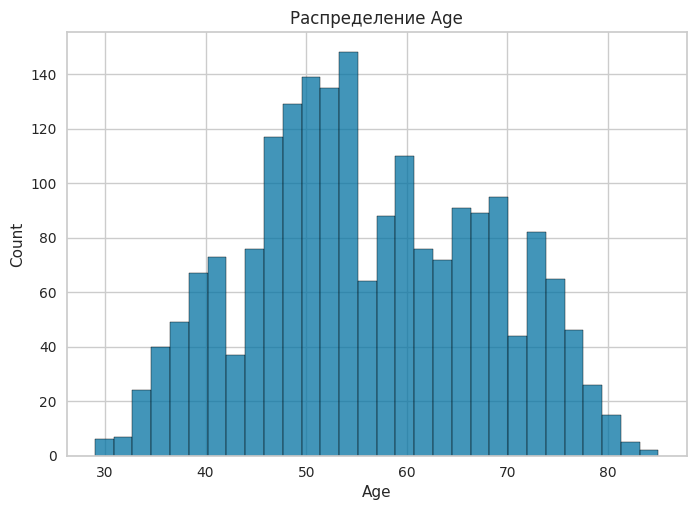

In [42]:
# Вывожу гистограмму распределения TotalSpent
sns.histplot(data['Age'], bins=30)
plt.title('Распределение Age')
plt.show()

По графику видим, что распределение на самом деле имеет колокообразную фотму, т.е. близко к нормальному распределение.

В данном случае, можно использовать t-test для проверки гипотез:

H0: Средний возраст у групп с Response =0 и Response =1 одинаков

H1: Средний возраст у групп с Response =0 и Response =1 отличается

In [43]:
# Разделяем по классам
age_0 = data[data['Response'] == 0]['Age']
age_1 = data[data['Response'] == 1]['Age']

In [44]:
# t-тест
t_stat, p_val = ttest_ind(age_0, age_1, equal_var=False)
print(f'T-test: t = {t_stat:.3f}, p = {p_val:.3f}')

T-test: t = 0.953, p = 0.341


p = 0.341 > 0.05 — значит нет статистически значимого основания отвергнуть H₀

По результатам t-теста признак AGE не является значимым для разделения классов в данной задаче.

Т.е. он, скорее всего, не даст сильного прироста качества модели при использовании  его в качестве единственного признака.

Однако, может быть данный признак пригодится при feature engineering.

Следующий числовой признак - это TotalPurchaseActivity

Чтобы понять распределение данных и есть ли выбросы - вывожу сводную статистику по признаку TotalPurchaseActivity:

In [45]:
print(data['TotalPurchaseActivity'].describe())

count              2017
mean    14.891918691125
std      7.596092036274
min                   0
25%                   8
50%                  15
75%                  21
max                  43
Name: TotalPurchaseActivity, dtype: float64


- Среднее и медиана близки - это говорит  о том, что распределение относительно симметричное, без сильного сдвига в одну сторону.

- Видем, что у некоторых пользователей почти нет активности когда у других очень высокая, т.е. широкий разброс значений --->  стандартное отлонение высокое =7.6

В качестве дополнения к числовой статистике вывожу график распределения признака:

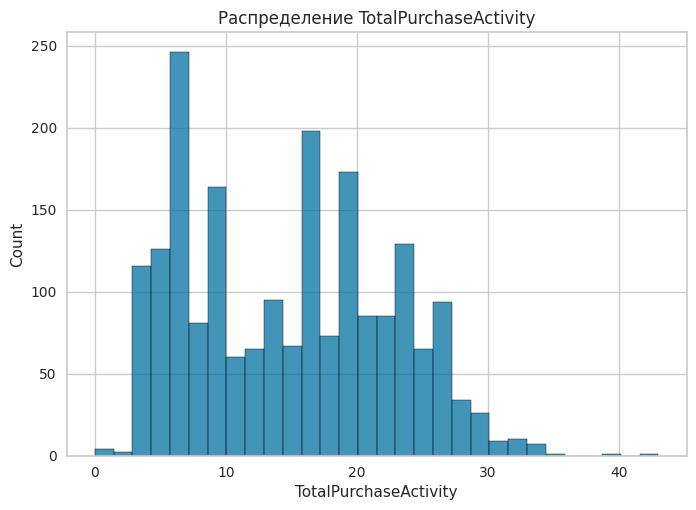

In [46]:
# Вывожу гисторгамму распределения признака
sns.histplot(data['TotalPurchaseActivity'], bins=30)
plt.title('Распределение TotalPurchaseActivity')
plt.show()

Выводы по графику:
- Распределение не нормальное.
- Есть выбросы. Их не много, но все что больше 35 похоже на выбросы.
- Основная масса данных сосредоточена в пределах 5–25 единиц активности.
- Низкая активность у некоторых пользователей. Столбец на уровне 0–1 показывает, что есть пользователи с почти нулевой покупательной активностью. 
Их поведение отличается и может быть важным для модели (возможно  как отдельный класс — "неактивные").

Оценю взаимосвязь TotalPurchaseActivity с целевой переменной Response:

In [47]:
# Группировка по Response и вывод статистик 
stats = data.groupby('Response')['Age'].describe()
display(stats)

,count,mean,std,min,25%,50%,75%,max
Response,,,,,,,,
0,1709,56.260386190755,11.532591231224,29,48,55,66,85
1,308,55.542207792208,12.284156170842,29,46,54.5,66,82


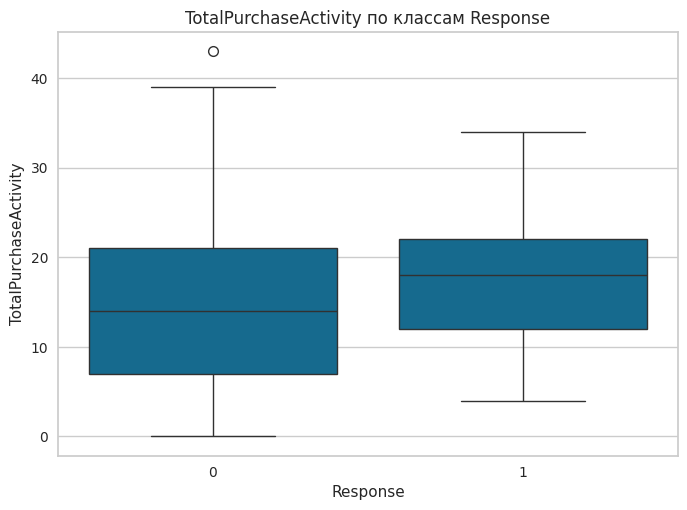

In [48]:
sns.boxplot(x='Response', y='TotalPurchaseActivity', data=data)
plt.title('TotalPurchaseActivity по классам Response')
plt.show()

Выводы по графику:
- Средняя активность выше у откликнувшихся--> откликнувшиеся пользователи более активны в покупках
- Все квартильные значения у Response выше--> откликнувшиеся пользователи более активны в покупках
- В группе Response=0 есть пользователи с нулевой активностью, тогда как в группе 1 — нет значений ниже 4. ---> нулевая активность может быть сильным предиктором отсутствия отклика
- Разброс чуть выше у неоткликнувшихся ---> более разнообразное поведение в этой группе.

Предварительный вывод по данному признаку:
- Данный признак информативен для модели
- Есть чёткая разница в распределении между группами
- Нулевые значения явно связаны с отсутствием отклика — стоит рассмотреть бинарный признак активности.

Применяю функцию IQR использовавшуюся выше для удаления выбросов в TotalPurchaseActivity:

In [49]:
columns_to_clean = ['TotalPurchaseActivity'] 

for col in columns_to_clean:
    original_shape = data.shape[0]
    data = remove_outliers_iqr(data, col)
    new_shape = data.shape[0]
    print(f"Удалено {original_shape - new_shape} выбросов из '{col}'.")

print(f"\nРазмер датасета без выбросов: {data.shape}")

Удалено 1 выбросов из 'TotalPurchaseActivity'.

Размер датасета без выбросов: (2016, 16)


Проожу стат тест для подтверждения гипотезы, что распределение TotalPurchaseActivity различаются между группами Response = 0 и Response = 1:

H0: Распределения TotalPurchaseActivity одинаковы для групп Response = 0 и Response = 1.

H1: Распределения TotalPurchaseActivity различаются между группами Response = 0 и Response = 1.

Так как распределение не нормальное, применяю непараметрический тест Mann–Whitney U test:

In [50]:
# Разделяю данные на группы
group0 = data[data['Response'] == 0]['TotalPurchaseActivity']
group1 = data[data['Response'] == 1]['TotalPurchaseActivity']

In [51]:
# применяю Mann-Whitney U test
stat, p_value = mannwhitneyu(group0, group1, alternative='two-sided')
print(f"Mann-Whitney U test: U = {stat:.3f}, p = {p_value:.5f}")

Mann-Whitney U test: U = 197371.500, p = 0.00000


Так как p-value < 0.05, мы отвергаем нулевую гипотезу.

Это значит, что распределения TotalPurchaseActivity в группах Response = 0 и Response = 1 статистически значимо различаются.

NumWebVisitsMonth - следующий числовой признак для анализа.

По традиции вывожу сводную статистику по данному признаку:

In [52]:
print(data['NumWebVisitsMonth'].describe())

count             2016
mean    5.347718253968
std     2.423340751729
min                  0
25%                  3
50%                  6
75%                  7
max                 20
Name: NumWebVisitsMonth, dtype: float64


- Половина пользователей посещает сайт 6 и более раз, что немного выше среднего, говорит о скошенности распределения.(50% = 6)
- Есть покупатели которые вообще не заходят на сайт (min=0)
- Стандартное отклонение (std) = 2.42 — есть умеренный разброс значений

Посмотрим на распределение данных:

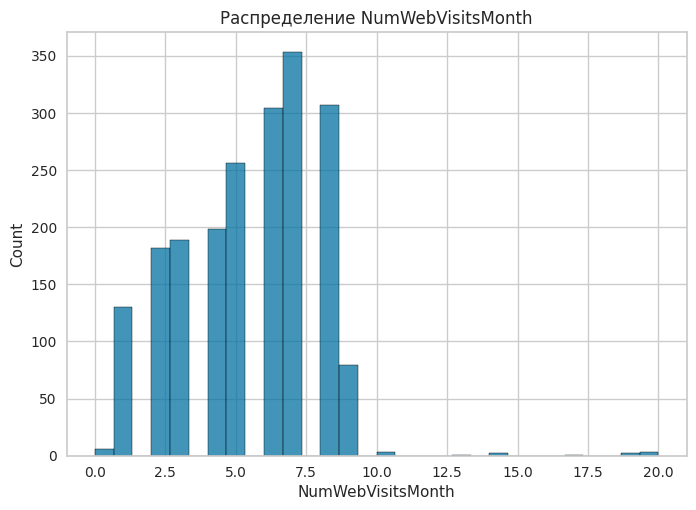

In [53]:
# Вывожу гисторгамму распределения признака
sns.histplot(data['NumWebVisitsMonth'], bins=30)
plt.title('Распределение NumWebVisitsMonth')
plt.show()

Гистограмма распределние указывает нам на несколько ключевых моментов:

- Распределение ненормальное
- Незначительное число покупателей посещают сайт очень часто( больше 10 раз). Что выглядит как аномалии
- Основная масса пользователей посещает сайт от 1 до 8 раз

Применяю IQR функцию для удаления выбросов:

In [54]:
columns_to_clean = ['NumWebVisitsMonth'] 

for col in columns_to_clean:
    original_shape = data.shape[0]
    data = remove_outliers_iqr(data, col)
    new_shape = data.shape[0]
    print(f"Удалено {original_shape - new_shape} выбросов из '{col}'.")

print(f"\nРазмер датасета без выбросов: {data.shape}")

Удалено 8 выбросов из 'NumWebVisitsMonth'.

Размер датасета без выбросов: (2008, 16)


In [55]:
# Группировка по Response и вывод статистик 
stats = data.groupby('Response')['NumWebVisitsMonth'].describe()
display(stats)

,count,mean,std,min,25%,50%,75%,max
Response,,,,,,,,
0,1700,5.292352941176,2.238790741373,0,4,6,7,13
1,308,5.327922077922,2.558679340568,1,3,6,8,10


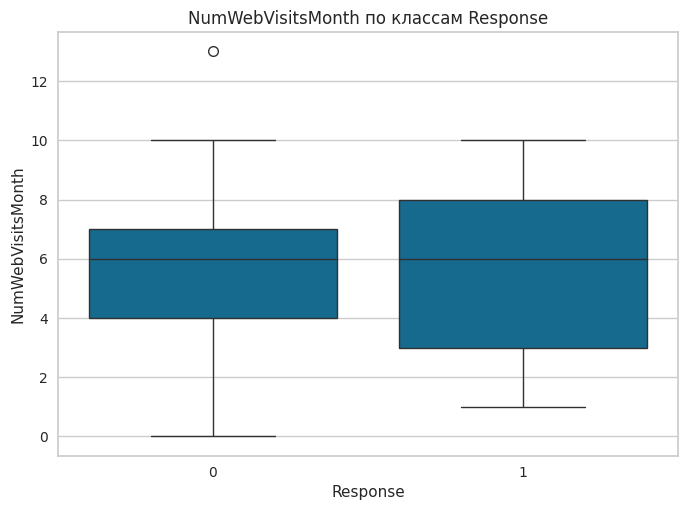

In [56]:
sns.boxplot(x='Response', y='NumWebVisitsMonth', data=data)
plt.title('NumWebVisitsMonth по классам Response')
plt.show()

Видим, что разница очень маленькая, почти нет отличий по центральным тенденциям:

- Для группы с Response=1  разброс немного выше (std = 2.56 против 2.24) -->  распределения похожи, с незначительными отличиями.
- Максимальные и минимальные значения в группах практически одинаковы -->  распределения похожи, с незначительными отличиями.
- 25% тоже отличается незначительно между группами -->  распределения похожи, с незначительными отличиями.
  
Т.е. количество визитов в месяц почти не отличается между теми, кто ответил положительно и отрицательно, а значит, сам по себе признак NumWebVisitsMonth в таком виде слабо коррелирует с Response и может не быть сильным предиктором.

Но, данный признак оставляю для  feature engineering

Переходим к следующему призкану - TotalAcceptedCmp.
Данный признак показывает участие в предыдущих кампаниях.

In [57]:
#Сводная статистика по признаку
print(data['TotalAcceptedCmp'].describe())

count             2008
mean    0.300796812749
std     0.679370266272
min                  0
25%                  0
50%                  0
75%                  0
max                  4
Name: TotalAcceptedCmp, dtype: float64


По сводной статистике видим в данных очень не сбалансированное распределение:

- Большинство покупателей не принимали участия ни в одной кампании (75% = 0)

- Лишь 25% принимали участие хотя  бы  в одной кампанию

Т.е. признак не имеет непрерывного распределения. Это счетчик событий.

Смотрим на распределение данных:
                               

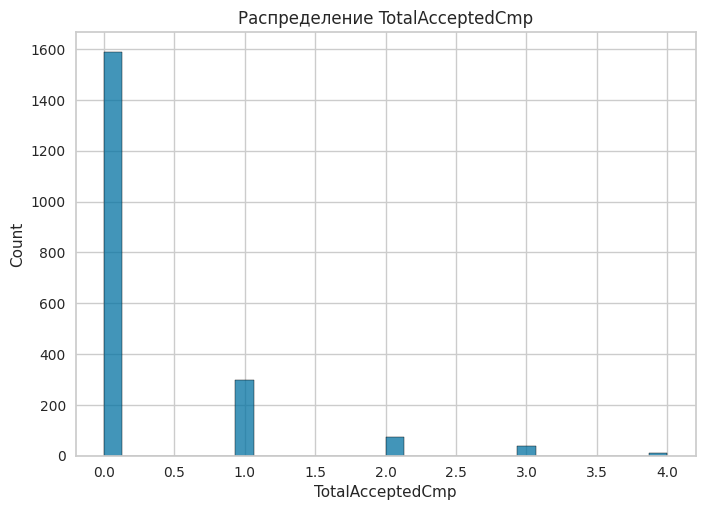

In [58]:
# Вывожу гисторгамму распределения признака
sns.histplot(data['TotalAcceptedCmp'], bins=30)
plt.title('Распределение TotalAcceptedCmp')
plt.show()

In [59]:
# Группировка по Response и вывод статистик 
stats = data.groupby('Response')['TotalAcceptedCmp'].describe()
display(stats)

,count,mean,std,min,25%,50%,75%,max
Response,,,,,,,,
0,1700,0.179411764706,0.474344386162,0,0,0,0,4
1,308,0.970779220779,1.113636255721,0,0,1,2,4


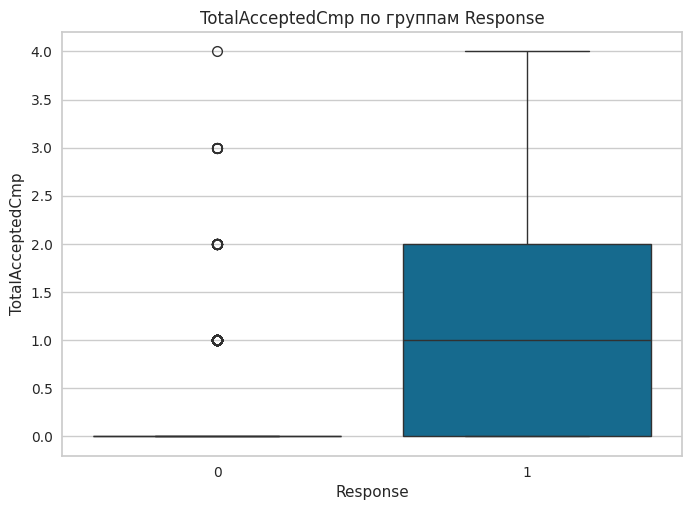

In [60]:
sns.boxplot(x='Response', y='TotalAcceptedCmp', data=data) 
plt.title('TotalAcceptedCmp по группам Response')
plt.show()

Данный график плохо отображает суть, т.к. большинство данных в группе Response = 0 сосредоточено вокруг 0. ((75% = 0), среднее значение = 0.179)

В отличие от этого, группа Response = 1 имеет среднее значение 0.971 и более высокое стандартное отклонение (1.114), с более равномерным распределением (25% на 0, 50% на 1, 75% на 2, максимум на 4). 

Это приводит к более широкому ящику на графике.

Поэтому для анализа влияние признака TotalAcceptedCmp на таргет, использую violin plot:

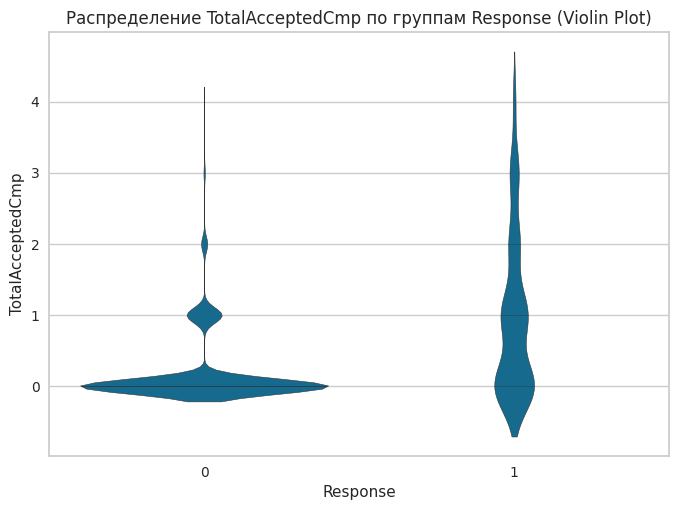

In [61]:
sns.violinplot(x='Response', y='TotalAcceptedCmp', data=data, inner='quartile')
plt.title('Распределение TotalAcceptedCmp по группам Response (Violin Plot)')
plt.xlabel('Response')
plt.ylabel('TotalAcceptedCmp')
plt.show()

Интерпретация графика violin plot:

1.Группа Response = 0:

- Большая часть данных сосредоточена около 0, что видно по широкой части "скрипки" внизу. Это подтверждает, что большинство значений в этой группе близки к 0.

- Узкие участки выше показывают, что значения выше 1 встречаются реже, а максимум (около 4) является редким выбросом.

- Распределение сильно скошено вправо, с высокой плотностью около 0

2.Группа Response = 1:

- Распределение более равномерное, с заметным увеличением значений от 0 до 2, что видно по более широкой форме "скрипки" в этом диапазоне.

- Максимум также достигает 4, но распределение имеет более выраженный пик около 1, с постепенным спадом к более высоким значениям.

- Плотность данных выше для значений от 0 до 2 по сравнению с группой Response = 0

В целом, график демонстрирует, что TotalAcceptedCmp сильно различается между группами: Response = 0 чаще имеет низкие значения, а Response = 1 — более высокие и разнообразные.

Изобразим данную зависимость при помощи столбчатой диаграммы:

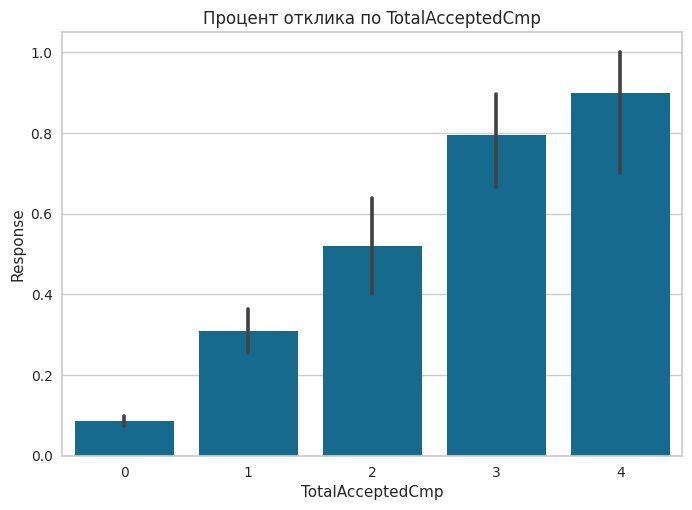

In [62]:
# Группировка по TotalAcceptedCmp и расчет доли Response
sns.barplot(x='TotalAcceptedCmp', y='Response', data=data)
plt.title("Процент отклика по TotalAcceptedCmp")
plt.show()

Еще раз убедились в том, что с  увеличением числа принятых кампаний доля положительных откликов растет и это может свидетельствовать о положительной корреляции между признаками TotalAcceptedCmp и Response.

В рамках исследовательского анализа посмотрим на взаимодействие TotalAcceptedCmp c Income:

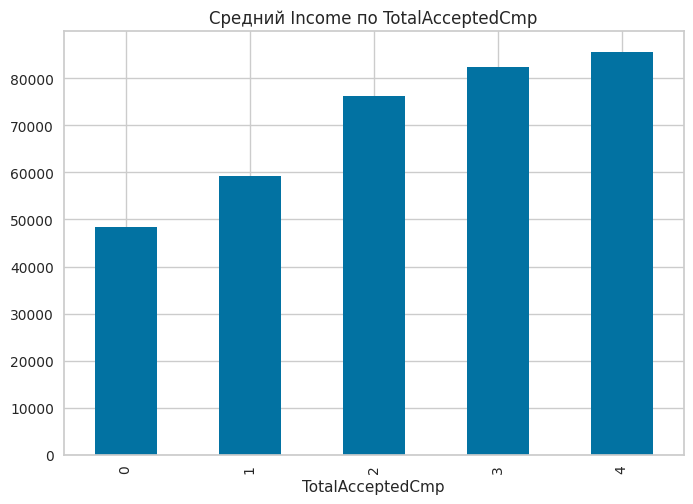

In [63]:
# Взаимосвязь с Income
data.groupby('TotalAcceptedCmp')['Income'].mean().plot(kind='bar')
plt.title("Средний Income по TotalAcceptedCmp")
plt.show()

С увеличением числа принятых кампаний (TotalAcceptedCmp) средний доход (Income) демонстрирует тенденцию к росту, что может указывать на положительную связь между активностью в кампаниях и уровнем дохода.

Общий вывод по анализу признака TotalAcceptedCmp:
- В среднем чем выше доход клиента, тем больше кампаний он принял---> вовлечённость в маркетинг выше у платёжеспособной аудитории.
- У клиентов, которые откликнулись, среднее значение TotalAcceptedCmp почти в 5 раз выше, чем у остальных.-->ранее откликнувшиеся на кампании клиенты более склонны к отклику в будущем.
- Доход (Income) и TotalAcceptedCmp связаны

Подводя итог по анализу и значимости признака TotalAcceptedCmp, можно смело сказать что практическая ценность данной перемнной высока для последуещего моделирования.
Т.к. диапазон значений признака = [1;4], привожу данный признак к бинарному типу:

In [64]:
# Новый признак откликался или нет вообще хоть на одну каманию 
data['AcceptedAnyCmp'] = (data['TotalAcceptedCmp'] > 0).astype(int)

Вывожу график с новым бинарным признаком AcceptedAnyCmp:

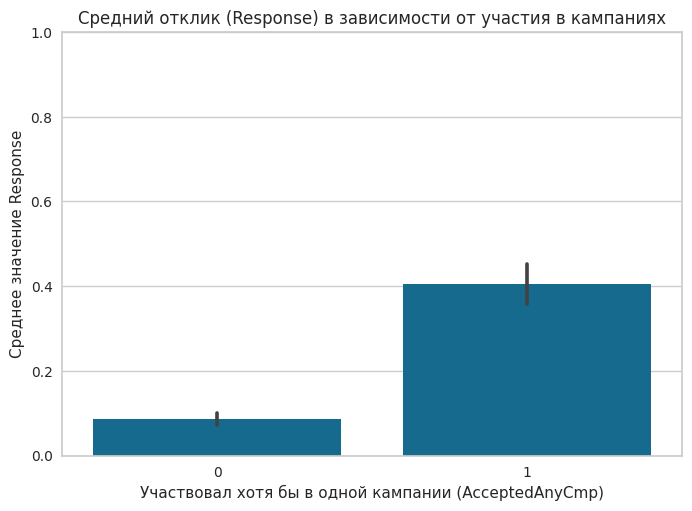

In [65]:
# Столбчатая диаграмма зависимости от AcceptedAnyCmp
sns.barplot(x='AcceptedAnyCmp', y='Response', data=data)
plt.title('Средний отклик (Response) в зависимости от участия в кампаниях')
plt.xlabel('Участвовал хотя бы в одной кампании (AcceptedAnyCmp)')
plt.ylabel('Среднее значение Response')
plt.ylim(0, 1)
plt.show()

С помощью кросс-таблицы вывожу численную информацию по графику (Сколько людей с AcceptedAnyCmp = 0 дали отклик (Response = 1) и сколько — нет):

In [66]:
# Кросс-таблица 
cross_tab = pd.crosstab(data['AcceptedAnyCmp'], data['Response'], margins=True)
print(cross_tab)

Response           0    1   All
AcceptedAnyCmp                 
0               1450  137  1587
1                250  171   421
All             1700  308  2008


По графику и кросс-таблице видим сильную зависимость между участием и отклико-Отклик в 5 раз выше у тех, кто участвовал хотя бы в одной кампании.

Вывожу сводную статистику по следующему числовому признаку - Recency:

In [67]:
#Сводная статистика по признаку
print(data['Recency'].describe())

count              2008
mean    48.909860557769
std     28.991611631178
min                   0
25%                  24
50%                  49
75%                  74
max                  99
Name: Recency, dtype: float64


- Медиана практически совпадает со средним значением, что указывает на симметричное распределение
- Аномалий по данным не наблюдаю

Вывожу график распределения:

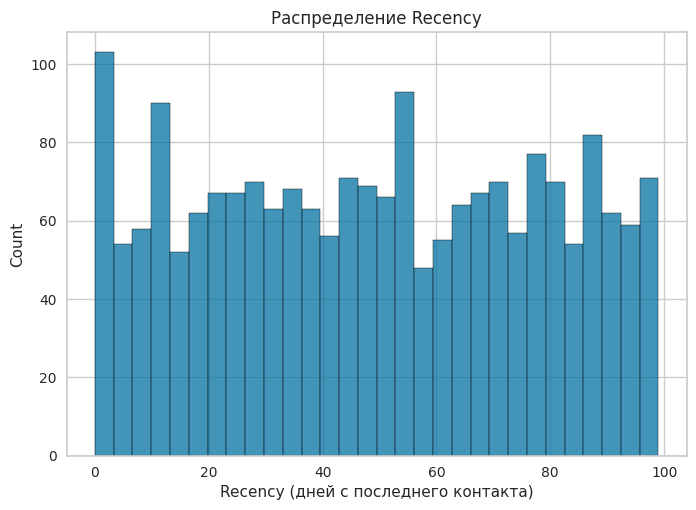

In [68]:
sns.histplot(data['Recency'], bins=30)
plt.title('Распределение Recency')
plt.xlabel('Recency (дней с последнего контакта)')
plt.show()

Данный график подтверждает мои предположения о симметричном распределении.

Вывожу bpxplot чтобы сранить группы по Respopnse:

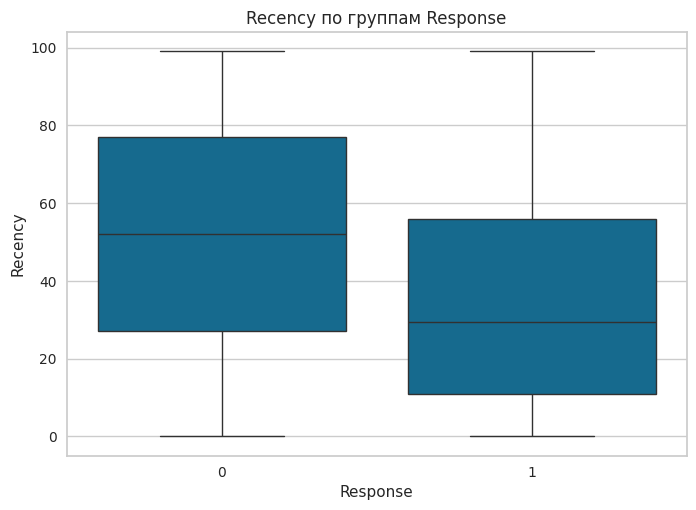

In [69]:
sns.boxplot(x='Response', y='Recency', data=data) 
plt.title('Recency по группам Response')
plt.show()

In [70]:
data.groupby('Response')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
Response,,,,,,,,
0,1700,51.436470588235,28.55522554145,0,27,52,77,99
1,308,34.964285714286,27.418377960352,0,11,29.5,56,99


Покупатели, которые откликнулись (Response = 1), в среднем имеют меньшее значение Recency — около 35 дней, в то время как покупатели, которые не откликнулись (Response = 0), имеют среднее значение около 51 дня.

Это говорит о том, что покупатели, недавно взаимодействовавшие с компанией, чаще откликаются на предложения.

Медианные значения подтверждают эту тенденцию: у откликнувшихся медиана Recency составляет 29.5 дней, а у остальных — 52 дня.

Следовательно, Recency является важным индикатором «теплоты» клиента — чем меньше прошло времени с последнего взаимодействия, тем выше вероятность отклика.

Посмотрим на связь между «теплотой» покупателя (то есть его активностью и постоянством) и откликом на предложение.

Для этого разобьём признак Recency на квантили и проанализируем, какая из полученных групп чаще откликается (Response = 1).:

In [71]:
#Разбивка Recency на квантили 
data['RecencyGroup'] = pd.qcut(data['Recency'], q=4, labels=['Очень недавние', 'Недавние', 'Средние', 'Давние'])

In [72]:
#Cредний отклик по группам
recency_response = data.groupby('RecencyGroup')['Response'].mean().reset_index()
print(recency_response)

     RecencyGroup       Response
0  Очень недавние 0.272015655577
1        Недавние 0.149402390438
2         Средние 0.114851485149
3          Давние 0.073469387755


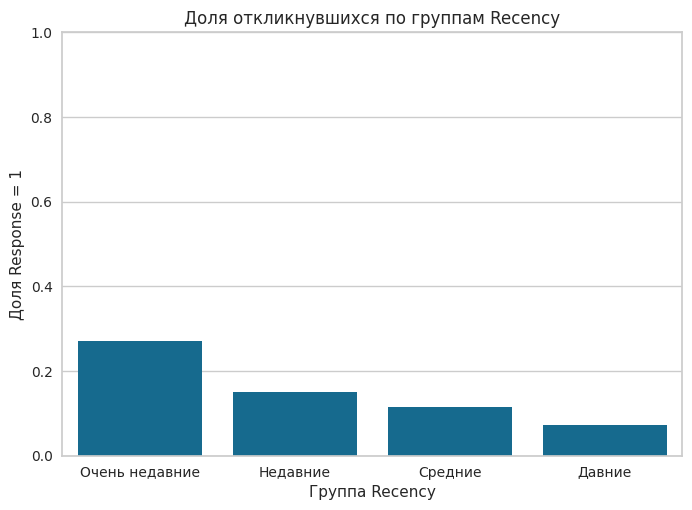

In [73]:
sns.barplot(x='RecencyGroup', y='Response', data=recency_response)
plt.title('Доля откликнувшихся по группам Recency')
plt.ylabel('Доля Response = 1')
plt.xlabel('Группа Recency')
plt.ylim(0, 1)
plt.show()

Признак Recency — информативен и значимо отличается между классами Response. 

Покупатели, которые недавно взаимодействовали с компанией, в несколько раз чаще откликаются на предложения. Он обязательно должен использоваться в модели.

Построим матрицу корреляции для ключевых числовых признаков, включая логарифмы расходов и дохода, возраст, активность клиента, а также целевую переменную Response.

Это позволит выявить линейные взаимосвязи и понять, какие из признаков могут быть потенциально информативны для предсказания отклика.

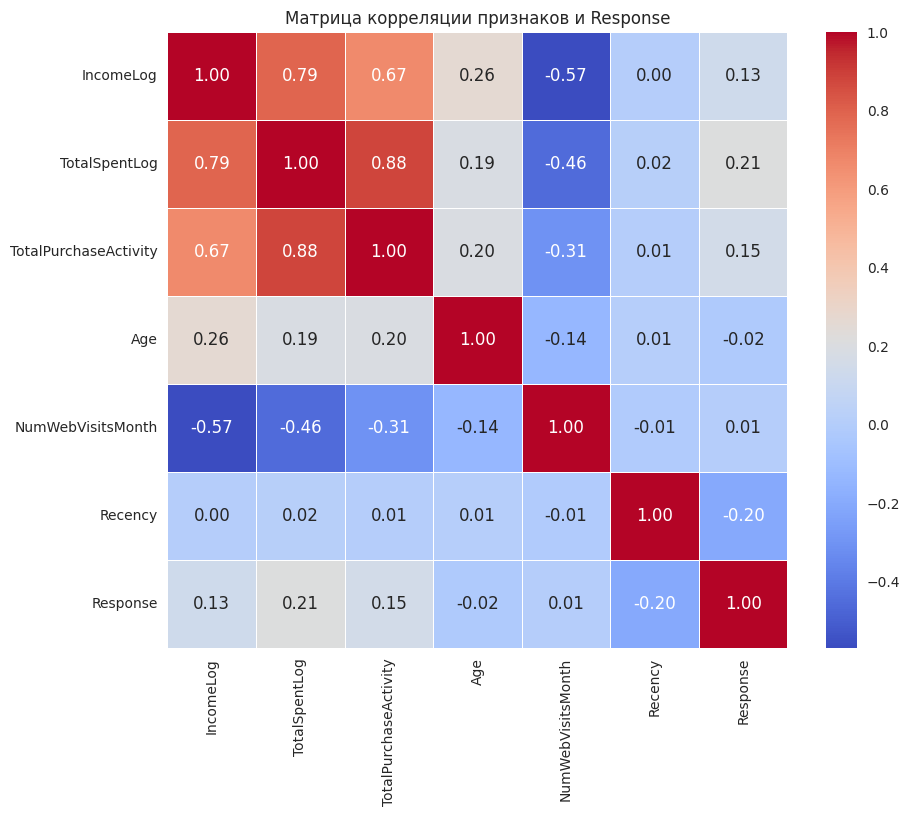

In [74]:
#Создаю список с числовыми переменными
corr_features = ['IncomeLog', 'TotalSpentLog', 'TotalPurchaseActivity', 
                 'Age', 'NumWebVisitsMonth', 'Recency', 'Response']

corr_matrix = data[corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Матрица корреляции признаков и Response')
plt.show()

Целевая переменная Response демонстрирует умеренную положительную корреляцию с признаками:
- TotalSpentLog 
- TotalPurchaseActivity
- IncomeLog 
что может свидетельствовать о том, что более платежеспособные и активные клиенты чаще откликаются на предложения

Сильная корреляция наблюдается:
-между TotalSpentLog и TotalPurchaseActivity 
-между IncomeLog и TotalSpentLog 

Recency имеет отрицательную связь с тагретом, что логично. Чем меньше времени прошло с последней покупки, тем выше вероятность отклика

Для построения модели буду учитывать следующие признаки 
- TotalSpentLog - т.к. данный признак отражает сумму трат + данный признак сильнее всего коррелирует с таргетом
- TotalPurchaseActivity - исключаю из-за сильной корреляции
- IncomeLog - попробую обучить с этим признаком и без него.
- Recency
- Age

Слабо коррелирующие признаки оставляю т.к. даже слабо коррелирующий признак может стать информативным в комбинации с другими. 

### Анализ категориальных признаков

На данном этапе перехожу к анализу кагегориальных признаков, а именно:

-HasChildren (наличие детей)

-MaritalFlag (семейное положение)

-HigherEducation (наличие высшего образования)

-IsHighIncome (наличие высокого дохода)

-AcceptedAnyCmp (участие в предыдущих кампаниях)

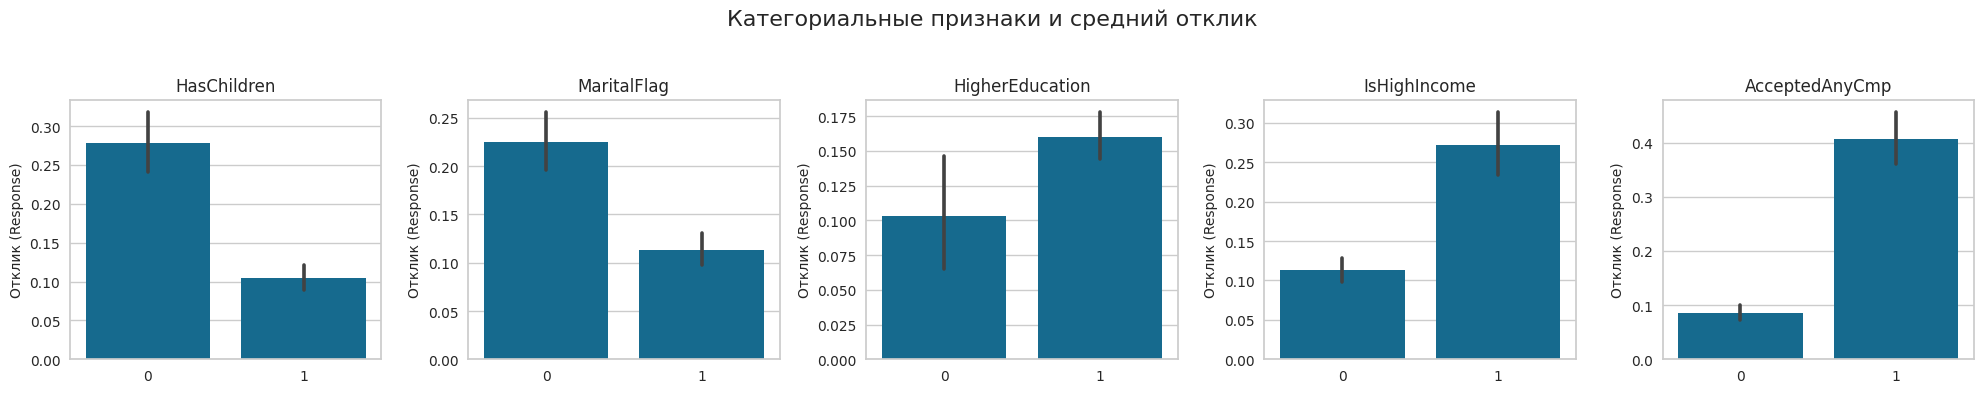

In [75]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
fig.tight_layout(pad=4)

cats = ['HasChildren', 'MaritalFlag', 'HigherEducation', 'IsHighIncome', 'AcceptedAnyCmp']

for i, col in enumerate(cats):
    sns.barplot(x=col, y='Response', data=data, estimator=np.mean, ax=axes[i])
    axes[i].set_title(f'{col}', fontsize=12)
    axes[i].set_ylabel('Отклик (Response)', fontsize=10)
    axes[i].set_xlabel('')

plt.suptitle('Категориальные признаки и средний отклик', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Вывод по графикам:
- HasChildren(наличие детей)
График показывает, что средний Response значительно отличается между группами с детьми  и без детей. 
Доля отличия между этими группами существенна, что может указывать на важность наличия детей как фактора, влияющего на отклик.

- MaritalFlag(семейное положение)
Наблюдается заметная разница в среднем Response между группами с разным семейным положением. 
Доля отличия также высока, что позволяет предположить, что семейное положение играет роль в уровне отклика.

- HigherEducation
График демонстрирует, что у людей с высшим образованием  средний Response выше, чем у тех, у кого его нет. 
Разница между группами выражена, но менее значительна по сравнению с другими факторами. 
Это может свидетельствовать о том, что высшее образование оказывает умеренное влияние на отклик.

- IsHighIncome
По графику видно, что покупатели с высоким доходом  демонстрируют более высокую долю отклика по сравнению с группой с низким доходом. 

- AccepteAnyCmp
Покупатели, участвовавшие в предыдущих маркетинговых кампаниях, демонстрируют значительно более высокий уровень отклика.
Это может указывать на то, что предыдущий положительный опыт взаимодействия с компанией способствует лояльности и готовности откликаться на маркетинговые предложения.

#### Обработка  дубликатов

In [76]:
df_model = data.copy()

In [77]:
to_drop = ['TotalAcceptedCmp', 'RecencyGroup', 'IncomeInterval', 
           'IncomeGroup', 'TotalPurchaseActivity', 'Income', 'TotalSpent']
df_model.drop(to_drop, axis=1, inplace=True)

In [78]:
#Вывожу дубликаты
duplicates = df_model[df_model.duplicated(keep='first')]

In [79]:
print(f"Найдено дубликатов: {duplicates.shape[0]}")

Найдено дубликатов: 0


In [80]:
total_duplicates = df_model.duplicated(keep=False).sum()
print(f"Всего полных дубликатов (включая все копии): {total_duplicates}")

Всего полных дубликатов (включая все копии): 0


In [83]:
df_model.shape

(2008, 11)

### Сохранение обработанных данных в файл

In [81]:
# Сохранение данных в файл
df_model.to_csv(processed_eda_data, index = False)
print(f'Сохранено в: {processed_eda_data}')

Сохранено в: /home/alorozhkov/jup/ml_projects/Marketing_Response/data/processed/MK_PROCESSED_EDA_DATA.csv
